In [11]:
import os
import math
import numpy as np
import json
import pickle

import pickle as pkl
import osmnx as ox

from tqdm import tqdm

from data import get_data
from random_walks import get_end_nodes, angle_diff
from utils import float2color

In [7]:
G, adj, boba_gdf = get_data("dartmouth")

In [19]:
edge_colors = []
edges = G.edges()
for u, v in tqdm(edges):
    for nbr, length, angle1, angle2 in adj[u]:
        if nbr == v: break
    
    edge_colors.append(float2color(
        (angle1 if angle1 > 0 else angle1 + np.pi) / (np.pi)
    ))

100%|██████████| 2400/2400 [00:00<00:00, 130597.56it/s]


In [20]:
edge_colors[:10]

['#ff0700',
 '#feff00',
 '#feff00',
 '#ff9500',
 '#feff00',
 '#feff00',
 '#feff00',
 '#feff00',
 '#ff1300',
 '#feff00']

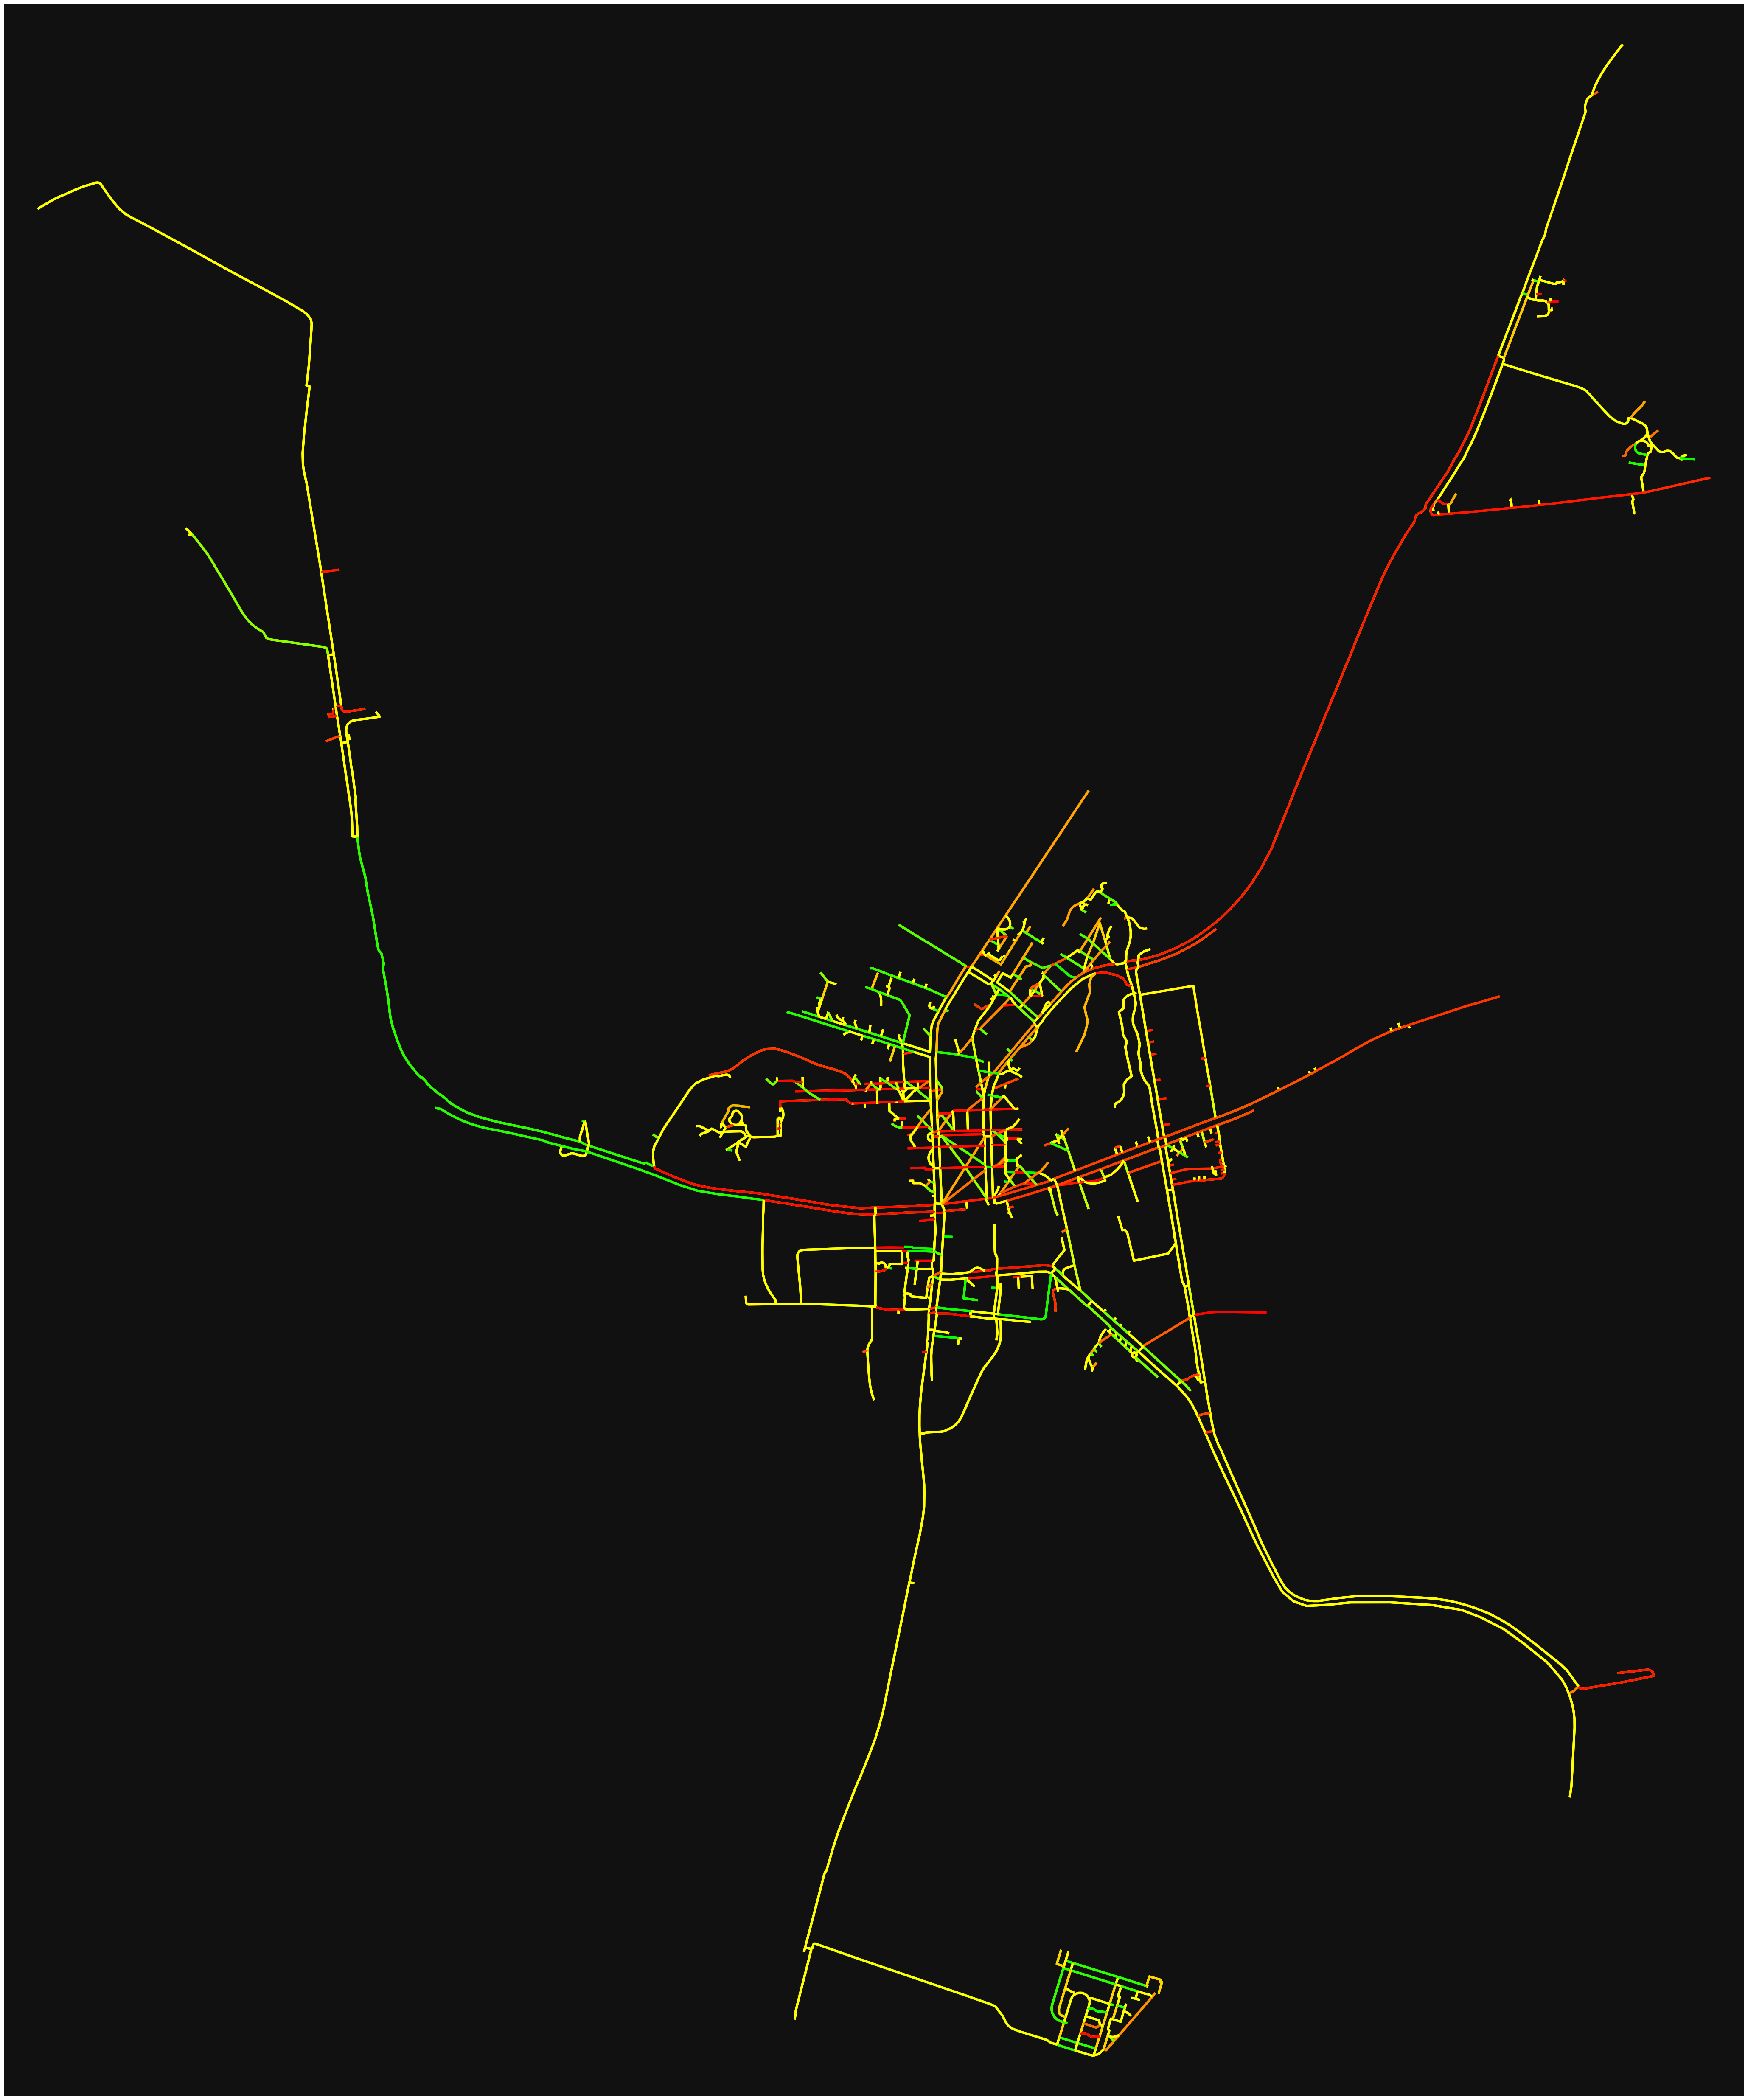

In [21]:
fig, ax = ox.plot_graph(
    G, figsize=(64, 64),
    edge_color=edge_colors,
    edge_linewidth=4, node_size=0
)